# Analysis on correlation between mainshocks and surface mass loading

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/home/amand4/notebooks/surface-load-quakes/loadquakes.py'>

### Load datasets (GRACE and declustered catalog)

In [2]:
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02CRI.nc")
# catalog = pd.read_csv('eq_200204_202102.csv')
catalog = pd.read_csv(dataset_path + 'ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

### Define mainshocks as events that have less than 10% chance of being triggered

In [3]:
mainshock = catalog[catalog['P_triggered']<.9]
mainshock

,target_id,latitude,longitude,time,magnitude,geometry,mu,P_triggered,P_background
49,53,2.6675,-59.5879,2021-01-31 19:05:14.367,5.5,POINT (2.6675 -59.5879),8.774521e-11,0.081552,0.918448
50,54,-13.9672,121.8641,2021-01-29 19:47:55.783,5.7,POINT (-13.9672 121.8641),8.774521e-11,0.634690,0.365310
54,58,18.2516,-64.0708,2021-01-24 23:21:41.140,5.4,POINT (18.2516 -64.07080000000001),8.774521e-11,0.829974,0.170026
73,77,-37.1225,-17.2548,2021-01-15 10:45:21.876,5.6,POINT (-37.1225 -17.2548),8.774521e-11,0.871333,0.128667
80,84,51.2811,100.4383,2021-01-11 21:32:59.015,6.7,POINT (51.2811 100.4383),8.774521e-11,0.729328,0.270672
...,...,...,...,...,...,...,...,...,...
9426,9430,84.2530,0.4080,2006-02-14 00:39:49.590,5.4,POINT (84.25299999999999 0.408),8.774521e-11,0.488028,0.511972
9427,9431,-62.2100,-158.1880,2006-02-13 03:23:35.610,5.4,POINT (-62.21 -158.188),8.774521e-11,0.878727,0.121273
9436,9440,66.2968,-142.6856,2006-02-05 08:17:01.373,5.4,POINT (66.2968 -142.6856),8.774521e-11,0.494733,0.505267
9437,9441,1.0930,-90.4600,2006-02-04 09:17:04.090,5.9,POINT (1.093 -90.45999999999999),8.774521e-11,0.700162,0.299838


In [4]:
# pd.options.mode.chained_assignment = 'warn'

### Add surface load to the mainshock dataframe

In [5]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data
  
mainshock['dmass'] = mainshock.apply(lambda row: get_mass(row), axis=1)

<ipython-input-5-127b551c338b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock['dmass'] = mainshock.apply(lambda row: get_mass(row), axis=1)


In [6]:
# # Distribution of all mainshocks

# gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(mainshock.longitude, mainshock.latitude))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
# gdf.plot(ax=ax, label='Distribution of earthquakes in catalog')
# leg = ax.legend()

In [83]:
mainshock.sort_values("magnitude")

,target_id,latitude,longitude,time,magnitude,geometry,mu,P_triggered,P_background,dmass,cp,loading_rate,cp_rate
9446,9450,1.6580,118.0090,2006-01-31 16:40:50.520,5.4,POINT (1.658 118.009),8.774521e-11,0.759523,0.240477,0.8901179295294139,0.931318,0.7045291303748303,0.975331
6058,6062,15.2160,-104.4740,2011-01-22 01:27:29.330,5.4,POINT (15.216 -104.474),8.774521e-11,0.732519,0.267481,0.9542326030143442,0.931318,-3.2184947101325667,1.224382
5745,5749,-10.2480,-13.2310,2011-03-19 18:43:03.250,5.4,POINT (-10.248 -13.231),8.774521e-11,0.675980,0.324020,0.5745609698705225,0.931318,-0.6340355358216312,1.001583
5692,5696,31.3730,100.7570,2011-04-10 09:02:47.380,5.4,POINT (31.373 100.757),8.774521e-11,0.844840,0.155160,-2.767903338047639,0.918188,1.4330499198763595,0.975331
5667,5671,-44.4670,-15.8460,2011-04-19 23:29:12.990,5.4,POINT (-44.467 -15.846),8.774521e-11,0.325199,0.674801,-0.16172586857887516,0.918188,-0.11398286721323636,0.975331
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,2795,-4.9521,94.3299,2016-03-02 12:49:48.110,7.8,POINT (-4.9521 94.32989999999999),8.774521e-11,0.574938,0.425062,-3.964177648605406,0.918188,1.0384266044361867,0.975331
3284,3288,28.2305,84.7314,2015-04-25 06:11:25.950,7.8,POINT (28.2305 84.73139999999999),8.774521e-11,0.509357,0.490643,-8.365726594830187,1.564716,-2.64158849928174,1.224382
1748,1752,56.0039,-149.1658,2018-01-23 09:31:40.890,7.9,POINT (56.0039 -149.1658),8.774521e-11,0.727191,0.272809,6.158104371354968,1.072122,4.270940717820741,1.375356
7862,7866,31.0020,103.3220,2008-05-12 06:28:01.570,7.9,POINT (31.002 103.322),8.774521e-11,0.214789,0.785211,-1.250807371134409,0.918188,-0.8833220814908027,1.001583


## Correlation between mainshocks and surface mass loading

In [29]:
# takes very long time to load:
# loadquakes.calc_stats(np.array(mainshock.dmass),np.array(ds['lwe_thickness'].data.flatten()))

{'cvm': CramerVonMisesResult(statistic=18.54565601407802, pvalue=3.6608838183127546e-09),
 'ks': KstestResult(statistic=0.04963563191122192, pvalue=0.1566585634353047),
 'median_all': 0.6627782418257632,
 'median_eq': 0.6096533443654473,
 'mean_all': -0.5782975724802435,
 'mean_eq': 0.28690678522417434,
 'mean_all_minus_mean_eq': -0.8652043577044178,
 'median_all_minus_median_eq': 0.0531248974603159}

21
20


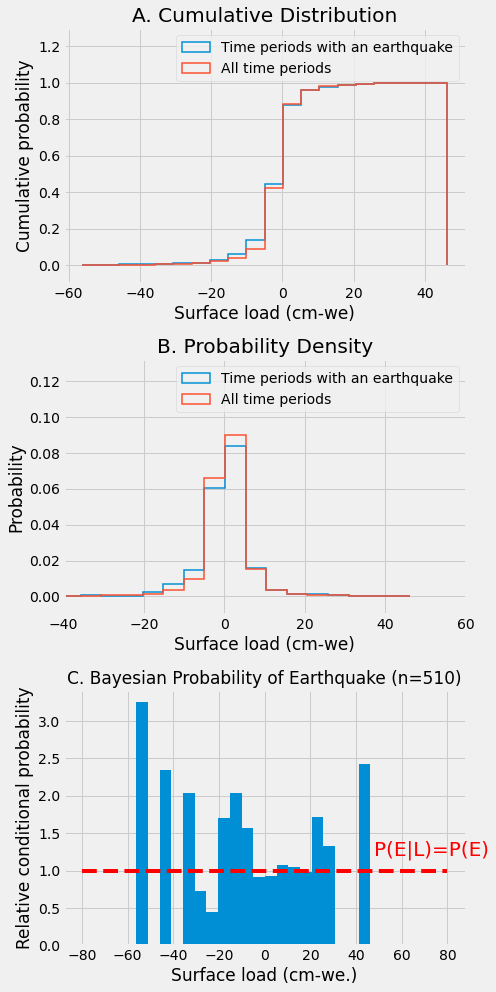

In [82]:
importlib.reload(loadquakes)
def set_of_figures_load(all_time, earthquake_only):

    fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(7,14))

    plt.style.use('fivethirtyeight')
    loadquakes.plot_hist(all_time, earthquake_only, ax1, ax2, 
              'A. Cumulative Distribution', 'B. Probability Density')

    loadquakes.plot_bayes(all_time, earthquake_only, ax3, 
                  'C. Bayesian Probability of Earthquake (n=510)')

    fig.tight_layout()
set_of_figures_load(ds['lwe_thickness'].data.flatten(), mainshock.dmass)

## Mapping earthquakes with high conditional probability

### First, calculate the conditional probability of each mainshock

<ipython-input-9-dd635c4c8f2e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock['cp'] = conditional_probability


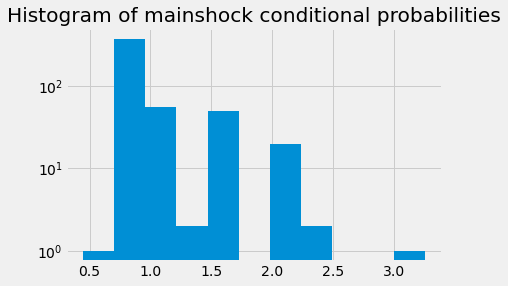

In [9]:
conditional_probability = loadquakes.get_cond_probability(
                            np.array(ds['lwe_thickness'].data.flatten()),
                            np.array(mainshock.dmass), np.array(mainshock.dmass))
mainshock['cp'] = conditional_probability
fig,ax=plt.subplots()
plt.hist(np.array(mainshock['cp']),11)
plt.title('Histogram of mainshock conditional probabilities')
plt.yscale('log')
# mainshock[mainshock.cp > 1.5].sort_values('cp')

### Next, map the events that have a conditional probability > 1.5                                       

In [86]:
mainshock[mainshock["cp"]>1.5].sort_values("magnitude")

,target_id,latitude,longitude,time,magnitude,geometry,mu,P_triggered,P_background,dmass,cp,loading_rate,cp_rate
3930,3934,4.1909,86.7252,2014-03-27 04:00:15.540,5.4,POINT (4.1909 86.7252),8.774521e-11,0.730205,0.269795,-11.677844038970811,2.038238,0.1342251588309047,0.975331
2879,2883,29.3985,81.6541,2015-12-18 22:16:56.550,5.4,POINT (29.3985 81.6541),8.774521e-11,0.890007,0.109993,-11.724276700447325,2.038238,-7.216615138957295,1.353465
4625,4629,31.8280,50.9540,2013-01-12 03:25:04.370,5.4,POINT (31.82800000000001 50.95399999999999),8.774521e-11,0.624569,0.375431,-6.778876826206092,1.564716,4.38107655575825,1.375356
2408,2412,39.4848,54.5087,2016-10-26 14:15:40.610,5.4,POINT (39.4848 54.5087),8.774521e-11,0.315486,0.684514,-8.088554645091927,1.564716,-1.0309223419963267,1.001583
8569,8573,6.7050,-72.9460,2007-05-06 04:47:13.680,5.4,POINT (6.705 -72.946),8.774521e-11,0.488851,0.511149,-13.613113423770603,2.038238,4.062651813030243,1.375356
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,4453,28.4280,51.5930,2013-04-09 11:52:49.920,6.4,POINT (28.428 51.593),8.774521e-11,0.873504,0.126496,-10.123261341462946,2.038238,-1.1077752113342285,1.001583
5202,5206,51.8420,95.9110,2011-12-27 15:21:56.840,6.6,POINT (51.842 95.911),8.774521e-11,0.444521,0.555479,-5.294499851234284,1.564716,1.7077793909324948,0.975331
8034,8038,10.6710,-41.8990,2008-02-08 09:38:14.100,6.9,POINT (10.671 -41.899),8.774521e-11,0.503263,0.496737,-5.282399920147915,1.564716,-0.9493823782966428,1.001583
5303,5307,38.7210,43.5080,2011-10-23 10:41:23.250,7.1,POINT (38.721 43.508),8.774521e-11,0.755150,0.244850,-5.257453518094782,1.564716,1.4400405276961052,0.975331


No handles with labels found to put in legend.


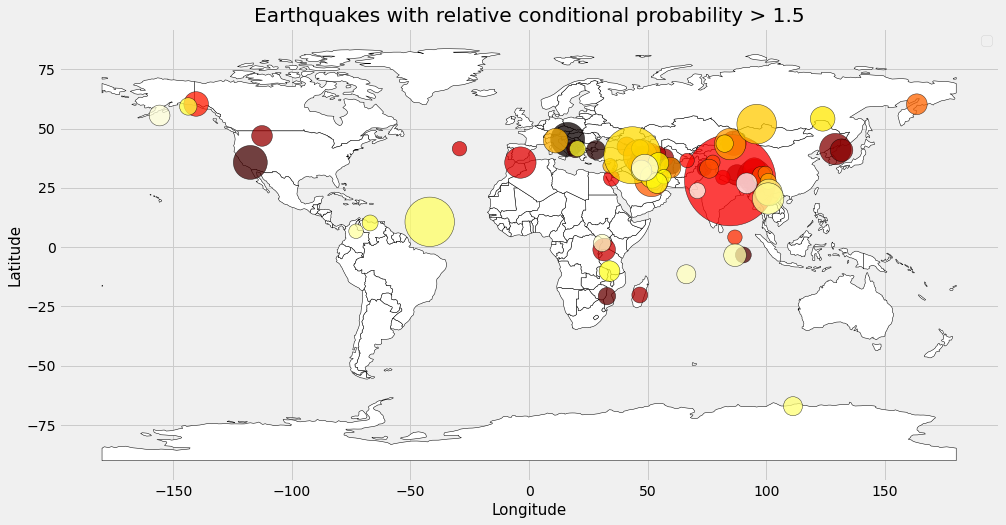

In [10]:
load_bounds = mainshock[mainshock['cp']>1.5]

def probability_map(load_bounds,color,label):

    gdf = gpd.GeoDataFrame(load_bounds,
                           geometry=gpd.points_from_xy(load_bounds.longitude, load_bounds.latitude))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))

    pl=gdf.plot(ax=ax, markersize = 1e-5*load_bounds.magnitude**10, 
             c = color/max(color), alpha=0.75, cmap='hot',
                edgecolor='k',legend=True)
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    leg = ax.legend()
    ax.set_title(label)
    plt.show()

probability_map(load_bounds,load_bounds.cp,
                'Earthquakes with relative conditional probability > 1.5')

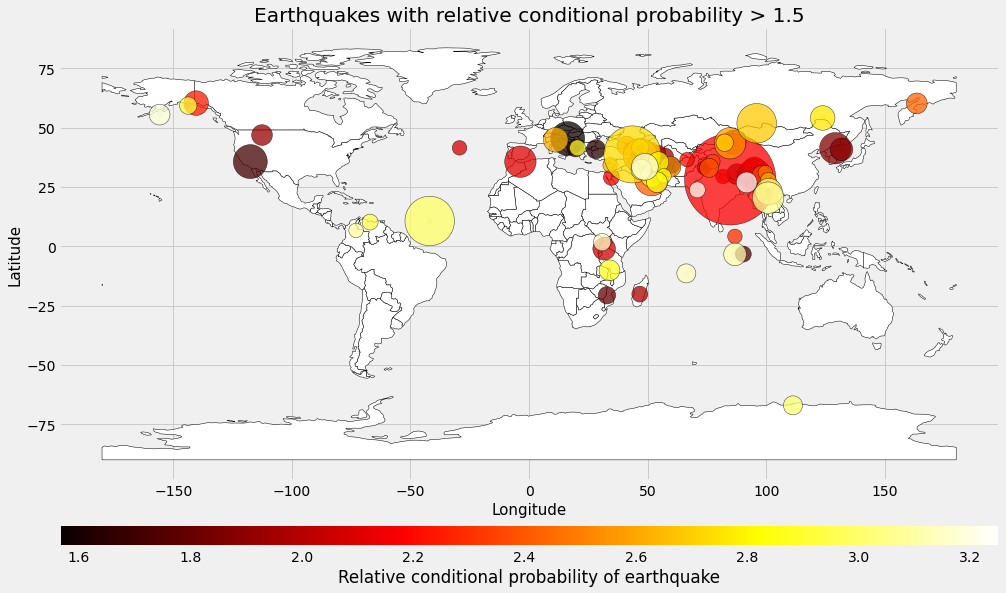

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
load_bounds = mainshock[mainshock['cp']>1.5]

def probability_map_cb(load_bounds,color,label):

    gdf = gpd.GeoDataFrame(load_bounds,
                           geometry=gpd.points_from_xy(load_bounds.longitude, 
                                                       load_bounds.latitude))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))

    gdf.plot(ax=ax, markersize = 1e-5*load_bounds.magnitude**10, 
             c=load_bounds.cp, alpha=0.75, cmap='hot',
                edgecolor='k',legend=True)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    gdf.plot(ax=ax,cax=cax,alpha=0.01,column=color,cmap='hot',legend=True,
            legend_kwds={'label': "Relative conditional probability of earthquake",
                            'orientation': "horizontal"})
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    ax.set_title(label)
    plt.show()

probability_map_cb(load_bounds,load_bounds.cp,
                'Earthquakes with relative conditional probability > 1.5')

In [ ]:
load_bounds.cp

## Correlation between mainshocks and rates of surface loading

### Calculate rates of loading

In [175]:
rates = ds['lwe_thickness'].diff('time')
rates.name = 'loading_rate'
ds['loading_rate'] = rates

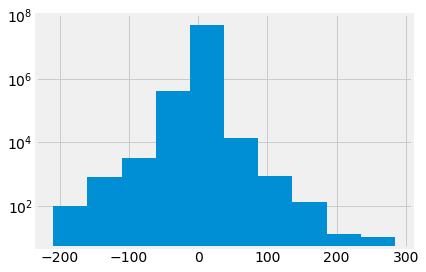

In [13]:
fig,ax=plt.subplots()
fig.patch.set_facecolor('w')
plt.hist(ds['loading_rate'].data.flatten())
plt.yscale('log')

In [14]:
def get_mass_rate(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["loading_rate"]
    return mass_change.data

mainshock['loading_rate'] = mainshock.apply(lambda row: get_mass_rate(row), axis=1)

<ipython-input-14-49c1da1e3fa6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock['loading_rate'] = mainshock.apply(lambda row: get_mass_rate(row), axis=1)


In [28]:
loadquakes.calc_stats(np.array(mainshock.loading_rate),np.array(ds['loading_rate'].data.flatten()))

{'cvm': CramerVonMisesResult(statistic=25093717328.75074, pvalue=0.0025406388631654675),
 'ks': KstestResult(statistic=0.04258563340857535, pvalue=0.3046628046046259),
 'median_all': nan,
 'median_eq': -0.1252215765497109,
 'mean_all': nan,
 'mean_eq': 0.0894192610713478,
 'mean_all_minus_mean_eq': nan,
 'median_all_minus_median_eq': nan}

In [ ]:
# np.nanmean(np.array(ds['loading_rate'].data.flatten()))

In [ ]:
# np.nanmedian(np.array(ds['loading_rate'].data.flatten()))

In [73]:
def set_of_figures_rate(all_time, earthquake_only):

    fig,(ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(6.5,12))

    plt.style.use('fivethirtyeight')
    loadquakes.plot_hist_rate(all_time, earthquake_only, ax1, ax2, 
              'A. Cumulative Distribution', 'B. Probability Density')

    loadquakes.plot_rel_hist_rate(all_time, earthquake_only, ax3, 
                  'C. Bayesian Probability of Earthquake (n=510)')

    fig.tight_layout()

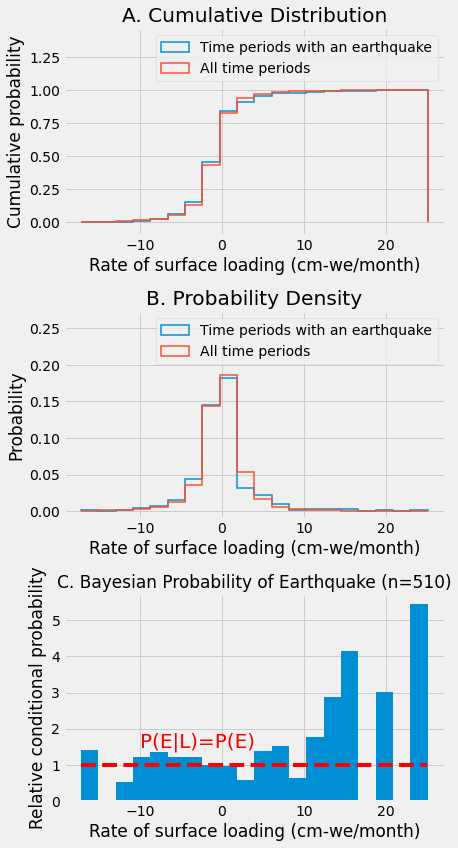

In [74]:
set_of_figures_rate(ds['loading_rate'].data.flatten(), mainshock.loading_rate)

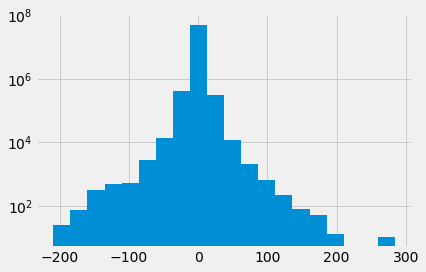

In [25]:
fig,ax=plt.subplots()
plt.hist(ds['loading_rate'].data.flatten(),20 )
plt.yscale('log')

In [26]:
conditional_probability_rate = loadquakes.get_cond_probability(
                                    np.array(ds['loading_rate'].data.flatten()),
                                    np.array(mainshock.loading_rate),
                                    np.array(mainshock.loading_rate))

mainshock['cp_rate'] = conditional_probability_rate

<ipython-input-26-09664389c60d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock['cp_rate'] = conditional_probability_rate


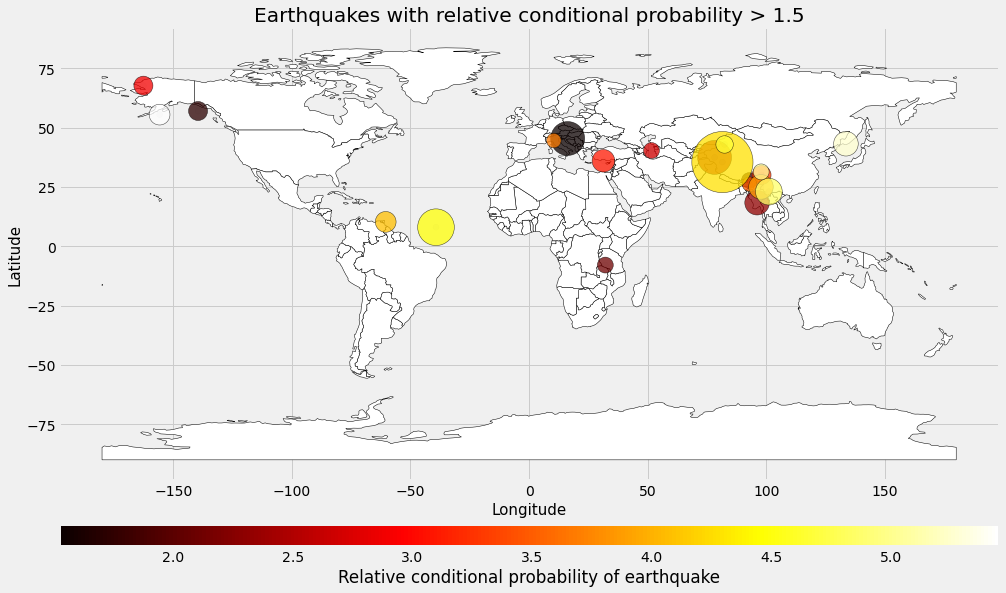

In [27]:
load_bounds = mainshock[mainshock['cp_rate']>1.5]

probability_map_cb(load_bounds,load_bounds.cp_rate,
                'Earthquakes with relative conditional probability > 1.5')

# Correlation between earthquakes and random data
##### *mean and std deviation of random array same as GRACE data 

In [197]:
random_load1 = np.random.normal(loc=-0.5782975724802435, scale=23.4860875337342, size=(194, 360, 720))

In [198]:
ds_random = ds

In [199]:
ds_random = ds_random.assign(load=ds_random['lwe_thickness'] - ds_random['lwe_thickness'] + random_load1)

In [200]:
ds_random['load']

<xarray.DataArray 'load' (time: 194, lat: 360, lon: 720)>
array([[[  2.42639426,  -4.46665108, -10.47158286, ..., -13.06400174,
          15.2509683 , -10.93409647],
        [-16.67475989,   3.07992435,  20.66447077, ..., -67.52700987,
          21.24322523,   5.06438688],
        [ 13.69974525,  11.41601577,  41.58511969, ...,  19.60714762,
          -6.95323236,   6.70671619],
        ...,
        [-18.03253154, -24.54620422, -11.64741678, ..., -37.93838914,
          -2.77697459,   7.12486321],
        [ 17.31327453,   0.23317593,   8.35072   , ...,  15.50322088,
           8.67510956,   5.8313534 ],
        [ -9.55597257,  15.86896248,  -0.29325392, ...,  28.30454204,
          24.89121376,  -4.62079017]],

       [[-35.43764388,  -0.44821768,  -4.8972808 , ..., -31.61831049,
           4.32266675,  -7.82323862],
        [  7.6661944 ,   9.06449415,  34.21572564, ..., -31.11485427,
          -6.80660744,  10.8287599 ],
        [-27.39398542,   9.23162278,  -7.28448338, ...,   3.58398731,
          19.18943402,  18.11722834],
...
        [ 16.13011439,  53.65602568, -27.24501548, ...,  -6.08457213,
          40.27414374,  16.77093372],
        [-30.41043568,   9.05559641,  -3.58562692, ..., -12.44141166,
         -38.51255376,  -9.66771349],
        [ 35.05677223,  10.4368678 ,   4.12491085, ...,  28.83568152,
          -6.44601523,  14.05503399]],

       [[  8.52229533,  30.51149074, -14.10173878, ..., -13.47408157,
           5.48473378,  12.18505342],
        [ 12.45872396,  12.85082076,   5.92513153, ...,  20.631442  ,
          29.97384174,  -6.32258246],
        [ 29.41291541,  17.75337987, -27.83053093, ...,   3.18190084,
         -16.64039799,  -4.0253663 ],
        ...,
        [ 30.1913433 ,  -9.69754367, -14.61325919, ...,   5.09469714,
         -36.95501973,  -1.36449938],
        [-21.11982072,  23.40203699,  21.46002826, ...,   5.6607712 ,
          36.93130793,  32.65376378],
        [-23.04892863, -43.05693666,  43.61687326, ..., -29.45686392,
           1.06410215, -20.95350202]]])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-02-15
  * lon      (lon) float64 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75

In [ ]:
# earthquake catalog

mainshock_random = catalog[catalog['P_triggered']<.9]

In [202]:
def get_mass_random(eq):
    mass_change = ds_random.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["load"]
    return mass_change.data
  
mainshock_random['dmass'] = mainshock_random.apply(lambda row: get_mass_random(row), axis=1)

<ipython-input-202-1efc1d20fd8f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mainshock_random['dmass'] = mainshock_random.apply(lambda row: get_mass_random(row), axis=1)


In [205]:
np.mean(mainshock_random['dmass'])

0.7010100884118273

In [206]:
np.std(mainshock_random['dmass'])

24.183244484132587

21
20


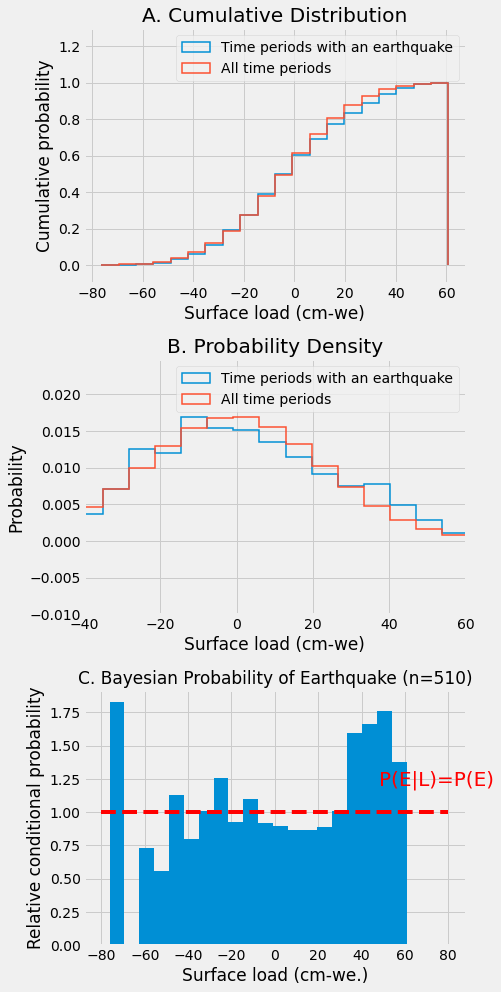

In [207]:
set_of_figures_load(ds_random['load'].data.flatten(), mainshock_random.dmass)

In [208]:
stats.ks_2samp(mainshock_random.dmass,ds_random['load'].data.flatten())

KstestResult(statistic=0.048805414944710246, pvalue=0.17035802763834784)